<a href="https://colab.research.google.com/gist/paruldiwakar/ccd3dde0cbda97281775bb66be994976/imagecaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Captioning
##Steps
- Data collection
- Understanding the data
- Data cleaning
- Loading the training set
- Data Preprocessing - Images (img --> vectors)
- Data Preprocessing - Captions (words --> vectors)
- Word Embeddings
- Model Architecture
- Inference

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from keras.utils import to_categorical

In [0]:
import json

In [0]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/flicker8k-dataset.zip" 

In [0]:
def readTextFile(path):

  with open(path) as f:
    captions = f.read()
  return captions


In [0]:
captions = readTextFile("/content/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
len(captions)

40460

In [0]:
# dictionary to map each image with list of captions

description = {}

for x in captions:
    img_name,cap= x.split("\t")
    img_name = img_name.split(".")[0] 
    
    # if the image name is not already present
    if description.get(img_name) is None:
        description[img_name] = []

    description[img_name].append(cap)  
  

In [0]:
description['1119015538_e8e796281e']

['A little tan dog with large ears running through the grass .',
 'A playful dog is running through the grass .',
 'A small dogs ears stick up as it runs in the grass .',
 'The small dog is running across the lawn .',
 'this is a small beige dog running through a grassy field']

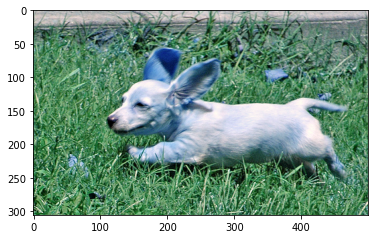

In [0]:
img_path = "/content/flicker8k-dataset/Flicker8k_Dataset/"

import cv2

img = cv2.imread(img_path +"1119015538_e8e796281e" +".jpg") 
plt.imshow(img)
plt.show()

## Data Cleaning

In [0]:
"""
1. lower case             # dont remove stopwards   
2. remove punctuations    # dont do stemming
3. remove len(words)<2
4. can remove special symbols like @,<,# etc
"""
import re

def clean_text(sample):
    sample = sample.lower()
    """
    substitute anything not[^] between a-b with space " " and ,
    + for 2 or more occurances of the preceeding character 
    """
    sample = re.sub("[^a-z]+"," ",sample) 
    sample = sample.split(" ")
    sample = [s for s in sample if len(s) > 1]
    sample = (" ").join(sample)
    return sample

In [0]:
# Modifying and cleaninig
for key,cap_list in description.items():
    for i in range(len(cap_list)):
        cap_list[i] = clean_text(cap_list[i])

In [0]:
#description['1119015538_e8e796281e']

In [0]:

with open("descriptions.txt","w") as f:
  f.write(str(description))


## Vocabulary

In [0]:
descriptions = None
with open("descriptions.txt","r") as f:
  descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

print(type(descriptions))

<class 'dict'>


In [0]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(sent.split()) for sent in descriptions[key]]

print("Vocab size : %d"%len(vocabulary))

Vocab size : 8424


In [0]:
# All word in descriptions
total_words = []

for key in descriptions.keys():
  #des is one caption in list of captions and i is one word in that caption
  [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words : %d"%len(total_words))    

Total words : 373837


In [0]:
# Filter words from the vocab according to certain threshold frquency

In [0]:
from collections import Counter

counter = Counter(total_words)
freq_cnt = dict(counter)
len(freq_cnt.keys())

8424

In [0]:
# sort the dictionary in descending order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), key= lambda x: x[1],reverse=True)

In [0]:
# Filter
threshold  = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]
#total_words

## Prepare Train/Test Data

In [0]:
train_file_data = readTextFile("/content/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt")    

In [0]:
train = [e[:-4] for e in train_file_data.split('\n')[:-1]]
test = [e[:-4] for e in test_file_data.split('\n')[:-1]]

In [0]:
#train

In [0]:
# Prepare Descriptions for Training data
# Tweak - Add a <s> and <e> token to our training data 

In [0]:
train_descriptions = {}

In [0]:
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "<s> "+cap+" <e>"
        train_descriptions[img_id].append(cap_to_append)

In [0]:
#train_descriptions['2752809449_632cd991b3']

# Data Preprocessing - Images

## Transfer Learning
- Images --> Features
- Text --> Features

##Step - 1 Image Feature Extraction

In [0]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.optimizers import Adam
from keras.preprocessing.image import image
from keras.preprocessing.sequence import pad_sequences

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [0]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
new_model = Model(inputs = model.input,outputs = model.layers[-2].output)
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
def preprocess_image(img):
  img = image.load_img(img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img) #normalises image array
  return img

In [0]:
'''
img = preprocess_image(img_path+"1119015538_e8e796281e.jpg")
plt.title(img.shape)
plt.imshow(img[0])
plt.show()
'''

'\nimg = preprocess_image(img_path+"1119015538_e8e796281e.jpg")\nplt.title(img.shape)\nplt.imshow(img[0])\nplt.show()\n'

In [0]:
def encode_image(img):
  img = preprocess_image(img)
  fea_vec = new_model.predict(img) # -->(1,2048)
  fea_vec = fea_vec.reshape((fea_vec.shape[1],)) # -->(2048,)
   
  return fea_vec

In [0]:
'''
sample: /content/flicker8k-dataset/Flicker8k_Dataset/1119015538_e8e796281e.jpg
'''

'\nsample: /content/flicker8k-dataset/Flicker8k_Dataset/1119015538_e8e796281e.jpg\n'

In [0]:
# img_id --> feature vector extracted from Resnet
start = time.time()

# key is file name and value is 2048 feature vectors
encoding_train = {}


for ix,img_id in enumerate(train):
  try:

    path = img_path+"/"+img_id+".jpg" 
    encoding_train[img_id] = encode_image(path)
  except:
    continue

  if ix%100 == 0:
    print("Encoding image :"+str(ix))

print("Time taken in sec :" + str(time.time()-start) )   


Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500
Encoding image :600
Encoding image :700
Encoding image :800
Encoding image :900
Encoding image :1000
Encoding image :1100
Encoding image :1200
Encoding image :1300
Encoding image :1400
Encoding image :1500
Encoding image :1600
Encoding image :1700
Encoding image :1800
Encoding image :1900
Encoding image :2000
Encoding image :2100
Encoding image :2200
Encoding image :2300
Encoding image :2400
Encoding image :2500
Encoding image :2600
Encoding image :2700
Encoding image :2800
Encoding image :2900
Encoding image :3000
Encoding image :3100
Encoding image :3200
Encoding image :3300
Encoding image :3400
Encoding image :3500
Encoding image :3600
Encoding image :3700
Encoding image :3800
Encoding image :3900
Encoding image :4000
Encoding image :4100
Encoding image :4200
Encoding image :4300
Encoding image :4400
Encoding image :4500
Encoding image :4600
Encoding image :4700
Enco

In [0]:
# Store everything to the disk //

with open("./encoded_train_images.pkl",'wb') as f:
  pickle.dump(encoding_train,f)

In [0]:
# img_id --> feature vector extracted from Resnet
start = time.time()

# key is file name and value is 2048 feature vectors
encoding_test = {}


for ix,img_id in enumerate(test):
  try:

    path = img_path+"/"+img_id+".jpg" 
    encoding_test[img_id] = encode_image(path)
  except:
    continue

  if ix%100 == 0:
    print("Encoding image :"+str(ix))

print("Time taken in sec :" + str(time.time()-start) )  

Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500
Encoding image :600
Encoding image :700
Encoding image :800
Encoding image :900
Time taken in sec :30.83183002471924


In [0]:
# Store everything to the disk //
with open("./encoded_test_images.pkl",'wb') as f:
  pickle.dump(encoding_test,f)

In [0]:
with open("./encoded_train_images.pkl",'rb') as f:
  encoding_train = pickle.load(f)
 
with open("./encoded_test_images.pkl",'rb') as f:
  encoding_test = pickle.load(f)

## Data Preprocessing - Captions

In [0]:
len(total_words)

1845

In [0]:
 word_to_idx = {}
 idx_to_word = {}


 for i,word in enumerate(total_words):
   word_to_idx[word] = i+1
   idx_to_word[i+1] = word


In [0]:
word_to_idx['dog']

6

In [0]:
idx_to_word[6]

'dog'

In [0]:
word_to_idx['<s>'] = 1846
word_to_idx['<e>'] = 1847
idx_to_word[1846] = '<s>'
idx_to_word[1847] = '<e>' 

In [0]:
vocab_size = len(idx_to_word) + 1

In [0]:
print("Vocab size : %d"%vocab_size)

Vocab size : 1848


In [0]:
all_caption_len = []

for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    all_caption_len.append(len(cap.split()))

max_len = max(all_caption_len) 
max_len   

35

## Data Loader (Gen)

In [0]:
#wei wuxian lan wangji wei ying lan zhan 


In [0]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):

  X1,X2,y = [],[],[]
  n = 0

  while True:
    for key,desc_list in train_descriptions.items():
      n+=1
      photo = encoding_train[key] 

      for desc in desc_list:

        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]

        for i in range(1,len(seq)):
          in_seq = seq[0:i]
          out_seq = seq[i]

          in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding='post')[0]
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:
        yield([np.array(X1),np.array(X2)],np.array(y))
        X1,X2,y = [],[],[]
        n=0


In [0]:
for i in data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  x,y = i
  print(y.shape)
  break

(147, 1848)


## Word Embeddings

In [0]:
f = open('/content/drive/My Drive/Colab Notebooks/glove.6B.50d.txt',encoding='utf-8')

embedding_index = {}

for line in f:
  values = line.split()
  word = values[0]
  word_embedding = np.asarray(values[1:],dtype='float')

  embedding_index[word] = word_embedding

f.close() 

In [0]:
#embedding_index["apple"]

In [0]:
def get_embedding_matrix():

  emb_dim = 50
  embedding_output = np.zeros((vocab_size,emb_dim)) 
  
  for word,idx in word_to_idx.items(): 
     embedding_vector = embedding_index.get(word)
     
     if embedding_vector is not None:
         embedding_output[idx] = embedding_vector

  return embedding_output

In [0]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## Model Architecture

In [0]:
# Image feature extraction

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [0]:
# Partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [0]:
'''
inp_img2(224x224 -> 2048 -> 256 dims)
inp_cap3(batch_sizex35 -> batch_sizex35x50 -> LSTM -> 256 dims)
inp_img2+inp_cap3 -> 256 dims -> 1847 dims -> softmax -> prob
'''
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1) 
output = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model

model = Model(inputs= [input_img_fea,input_cap], outputs = output)

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [0]:
# Important - Embedding Layer
#(initialising the embedding layer in Model with predefined embedding matrix)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Training Model 

In [0]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//12

In [0]:
for i in range(epochs):
  gen = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
  model.fit_generator(gen,epochs=1,steps_per_epoch=steps,verbose=1)
 

500/500 [==============================] - 34s 68ms/step - loss: 2.0486


#Predictions

In [0]:
def predict_caption(photo):

  in_text = "<s>"
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    y_pred = model.predict([photo,sequence])
    y_pred = y_pred.argmax()
    word = idx_to_word[y_pred]
    in_text += (' '+ word)
    
    if word == '<e>':
      break

  final_caption = in_text[3:-3]  
  final_caption = ''.join(final_caption)

  return final_caption

In [0]:
# Pick some random images and see results

for i in range(15):
  idx = np.random.randint(0,1000)
  all_img_name = list(encoding_test.keys())
  img_name = all_img_name[idx]
  photo_2048 = encoding_test[img_name].reshape((1,2048))
  
  i = plt.imread(img_path+img_name+".jpg")
  caption = predict_caption(photo_2048)
  print(caption + ".")
  plt.imshow(i)
  plt.show()